In [39]:
import imageio
import numpy as np

vid_fp = '/home/ubuntu/data/bomb.mp4'
start_sec = 25.
end_sec = 35.
bw = True
keep = 2

vid = imageio.get_reader(vid_fp)
fps = vid.get_meta_data()['fps']
print fps

if start_sec:
    start_frame = int(start_sec * fps)
    end_frame = int(end_sec * fps)
else:
    start_frame = -1
    end_frame = 10000000

frames = []
try:
    for i, im in enumerate(vid):
        if i < start_frame:
            continue
        if i >= end_frame:
            break
        frames.append(im)
except:
    pass

frames = np.array(frames)

frames = frames[::keep]
fps /= keep

if bw:
    frames = frames[:, :, :, :1]

frames = frames.astype(np.float32)
frames /= 255.
frames *= 2.
frames -= 1.

print frames.shape[0]

frame_shape = frames.shape[1:]
print frame_shape

29.97
150
(360, 490, 1)


In [40]:
from sklearn.decomposition import PCA, FastICA

k = 128
alg = 'pca'

examples = np.reshape(frames, [frames.shape[0], -1])
print examples.shape

if alg == 'pca':
    pca = PCA(n_components=k)
    pca.fit(examples)
    
    A = pca.components_
    W = A.T
elif alg == 'ica': 
    ica = FastICA(n_components=k)
    ica.fit(examples)
    
    A = ica.components_
    W = ica.mixing_
else:
    raise NotImplementedError()

print W.shape

(150, 176400)
(176400, 128)


Populating the interactive namespace from numpy and matplotlib


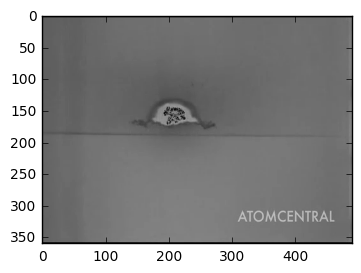

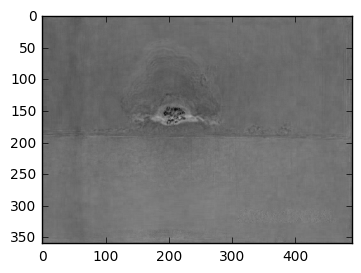

In [41]:
%pylab inline

i = 0

def float_to_uint8(x):
    x = np.copy(x)
    
    x += 1.
    x /= 2.
    x *= 255.
    x = np.clip(x, 0., 255.)
    
    return x.astype(np.uint8)

def display_img(img, name=None, figsize=(4, 4)):
    if img.shape[0] == reduce(lambda x, y: x * y, frame_shape):
        img = np.reshape(img, frame_shape)
    
    if bw:
        img = np.repeat(img, 3, axis=2)
    
    fig = pylab.figure(figsize=figsize)
    if name:
        fig.suptitle(name, fontsize=20)
    pylab.imshow(img)

frame_0 = examples[i]
frame_0_pca = np.matmul(frame_0, W)
frame_0_recons = np.matmul(frame_0_pca, A)

display_img(float_to_uint8(frame_0))
display_img(float_to_uint8(frame_0_recons))

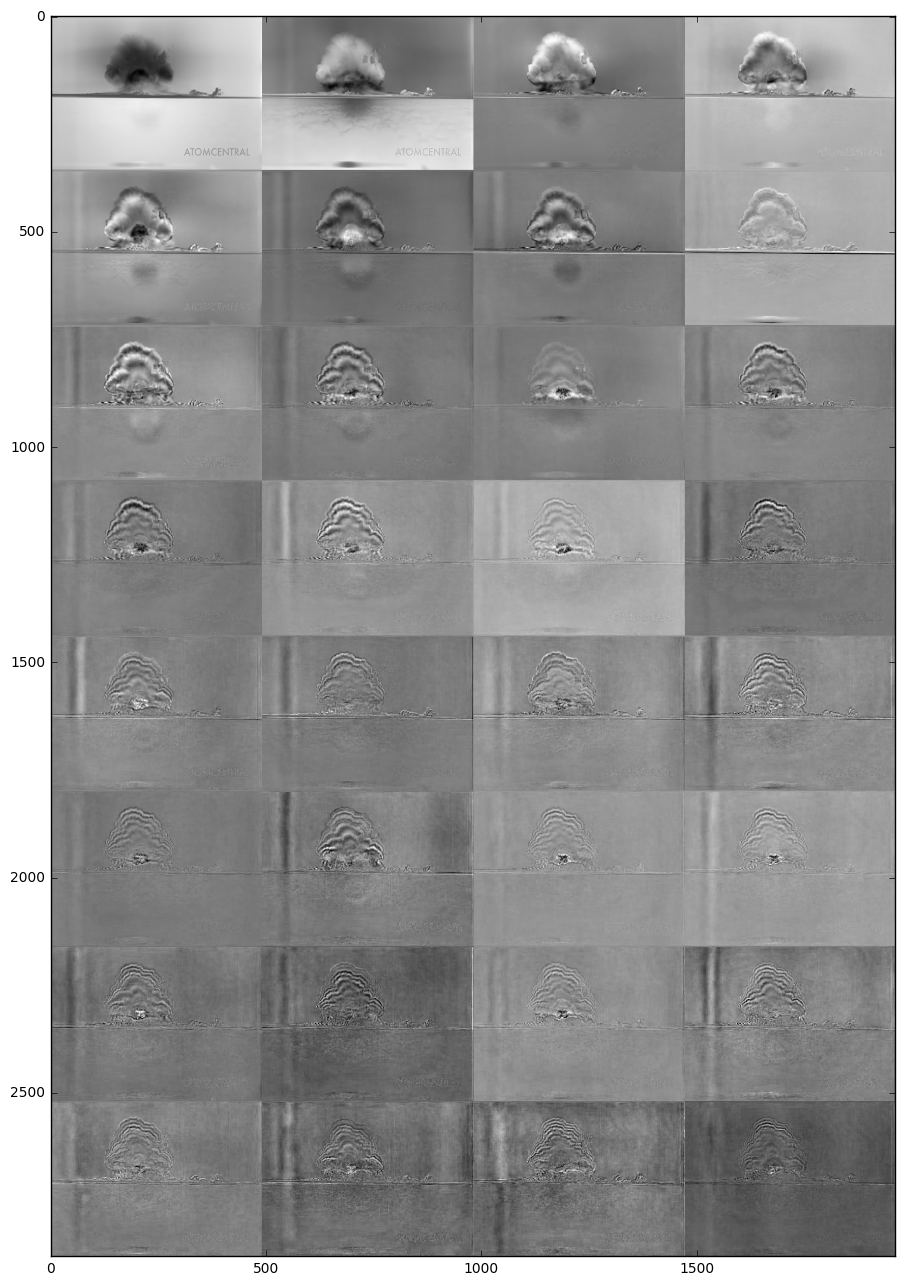

In [42]:
k_dim = [8, 4]

k_show = reduce(lambda x, y: x * y, k_dim)

Aprev = np.empty([k_dim[0] * frame_shape[0], k_dim[1] * frame_shape[1], frame_shape[2]], np.uint8)

k = 0
for i in xrange(k_dim[0]):
    for j in xrange(k_dim[1]):
        y = i * frame_shape[0]
        x = j * frame_shape[1]
        a = np.copy(A[k])
        a += np.abs(a.min())
        a /= a.max()
        a *= 2.
        a -= 1.
        a = float_to_uint8(a)
        a = np.reshape(a, frame_shape)
        Aprev[y:y+frame_shape[0], x:x+frame_shape[1]] = a
        k += 1

display_img(Aprev, figsize=(16, 16))

In [43]:
import imageio
import os

name = os.path.splitext(os.path.split(vid_fp)[1])[0]

writer = imageio.get_writer('/home/ubuntu/data/{}_orig.mp4'.format(name), fps=fps)

for frame in examples:
    frame_uint8 = float_to_uint8(frame)
    frame_uint8 = np.reshape(frame_uint8, frame_shape)

    writer.append_data(frame_uint8)
writer.close()

for k in [1, 2, 4, 8, 16, 32, 64, 128]:
    writer = imageio.get_writer('/home/ubuntu/data/{}_{}{}.mp4'.format(name, alg, str(k).zfill(4)), fps=fps)

    vid_pca = np.matmul(examples, W[:, :k])
    vid_recons = np.matmul(vid_pca, A[:k])

    for frame in vid_recons:
        frame_uint8 = float_to_uint8(frame)
        frame_uint8 = np.reshape(frame_uint8, frame_shape)

        writer.append_data(frame_uint8)
    writer.close()

In [44]:
import io
import base64
from IPython.display import HTML, display

for k in [None, 1, 4, 16, 128]:
    if k is None:
        print 'Original'
        name = 'orig'
    else:
        print 'Reconstruction with {} components'.format(k)
        name = '{}{}'.format(alg, str(k).zfill(4))
    video = io.open('/home/ubuntu/data/bomb_{}.mp4'.format(name), 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

Original


Reconstruction with 1 components


Reconstruction with 4 components


Reconstruction with 16 components


Reconstruction with 128 components
